**This notebook creates image patches from all of the test set (center 4) samples. No 50/50 normal/tumor sampling.**

In [1]:
# add ASAP path to sys to locate the multiresolutionimageinterface
import sys
sys.path.append('/opt/ASAP/bin')
# required libraries
import multiresolutionimageinterface as mir
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook

In [2]:
# Image size
sz = 256
# Levels to sample
levels = [0,2]

In [3]:
# directory to save patches
dirPatches = 'data/test_patches/'

df = pd.read_csv('data/training/center_4.csv').set_index('Unnamed: 0')
len(df)

2143729

When making pathes, it is faster to process all patches from one WSI at the time, so we should loop over each WSI.

In [12]:
dirData = 'data/training/'
ImageFiles = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dirData):
    for file in f:
        if '.tif' in file and 'mask' not in file:
            split = r.split('/')
            cnt = int(split[2].strip('center_'))
            if(cnt == 4):
                ImageFiles.append(os.path.join(r, file))
len(ImageFiles)

100

In [13]:
def getSamples(mr_image, x_cent, y_cent, levels=[0,3]):
    channels = 3
    imgs = np.zeros((len(levels), sz, sz, channels), dtype=np.uint8)
    for i, lev in enumerate(levels):
        ds = mr_image.getLevelDownsample(lev)
        imgs[i] = mr_image.getUCharPatch(int(x_cent - (ds*sz/2)),
                                         int(y_cent - (ds*sz/2)),
                                         sz,
                                         sz,
                                         lev)
    return imgs

In [14]:
for WSI in tqdm_notebook(ImageFiles, "Patches from WSI's"):
    # extract patient and node from the WSI path
    split = WSI.split('/')
    cnt = int(split[2].strip('center_'))
    if cnt != 4:
        continue
    splitpatient = split[3].split('_')
    patient = int(splitpatient[1])
    node = int(splitpatient[3].strip('.tif'))
    
    # then, subsample the df to get only pathes from this WSI
    df_sub = df[(df.patient == patient) & (df.node == node)]
    
    # load WSI image
    reader = mir.MultiResolutionImageReader()
    mr_image = reader.open(WSI)
    
    for i in range(len(df_sub)):
        id = str(df_sub.iloc[i].patchId)
        fileNamePrefix = dirPatches + id
        
        center_x = df_sub.iloc[i].centerX
        center_y = df_sub.iloc[i].centerY
        
        # note the flipped order of x and y
        imgs = getSamples(mr_image, center_y, center_x, levels)
        for lev_index, img in enumerate(imgs):
            fileName = fileNamePrefix + '_' + str(levels[lev_index]) + '.png'
            cv2.imwrite(fileName, img)

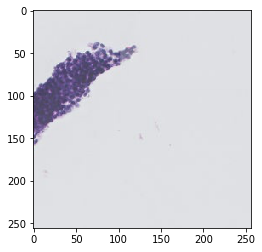

In [15]:
test_image = cv2.imread('./data/test_patches/80000021760079744_2.png')
plt.imshow(test_image)